In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModel
import torch

In [2]:
viral_df = pd.read_csv("../processed_data/mmseqs_searches/viral_proteins.csv")
viral_df

,query,target,evalue,bitscore,query_length,frac_ident,taxid,taxname
0,AFLTNVPYKRIEELL,Q9QR98,0.000162,37,15,1.000,11908,Human T-cell leukemia virus type I
1,AFLTNVPYKRIEELL,Q9DTK6,0.000162,37,15,1.000,194440,Primate T-lymphotropic virus 1
2,AFLTNVPYKRIEELL,A0A8F7GK75,0.000162,37,15,1.000,11908,Human T-cell leukemia virus type I
3,AFLTNVPYKRIEELL,Q85611,0.000162,37,15,1.000,11908,Human T-cell leukemia virus type I
4,AFLTNVPYKRIEELL,Q86737,0.000512,36,15,0.933,36369,Simian T-lymphotropic retrovirus type 1F
...,...,...,...,...,...,...,...,...
186485,YLTVFTVYL,Q9IR54,315.300000,19,9,0.875,129724,human papillomavirus 82
186486,YLTVFTVYL,A0A2Z6BEJ1,315.300000,19,9,0.666,2731619,Caudoviricetes
186487,YLTVFTVYL,W5S519,315.300000,19,9,0.875,1450746,Pithovirus sibericum
186488,YLTVFTVYL,A0A6G9RV59,315.300000,19,9,0.750,2719442,Plasmopara viticola lesion associated mitoviru...


In [8]:
len(viral_df["taxname"].unique())

15030

In [10]:
species = ["Human"] + viral_df["taxname"].tolist()
species[:10]

['Human',
 'Human T-cell leukemia virus type I',
 'Primate T-lymphotropic virus 1',
 'Human T-cell leukemia virus type I',
 'Human T-cell leukemia virus type I',
 'Simian T-lymphotropic retrovirus type 1F',
 'Human T-cell leukemia virus type I',
 'Primate T-lymphotropic virus 1',
 'Primate T-lymphotropic virus 1',
 'Simian T-lymphotropic virus 1']

In [15]:


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-large-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-large-en-v1.5')
model.eval()

batch_size=100

species_embeddings = []
n_batch = 0
for i in tqdm(range(0, len(species)+1, batch_size)):
    # Tokenize sentences
    sentences = species[i:i+batch_size]
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    # for s2p(short query to long passage) retrieval task, add an instruction to query (not add instruction for passages)
    # encoded_input = tokenizer([instruction + q for q in queries], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        # Perform pooling. In this case, cls pooling.
        sentence_embeddings = model_output[0][:, 0]
    # normalize embeddings
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    species_embeddings.append(sentence_embeddings.detach().numpy())
    n_batch += 1
    if n_batch>10:
        break
species_embeddings = np.vstack(species_embeddings)
species_embeddings.shape

  0%|          | 0/1865 [00:00<?, ?it/s]

(1100, 1024)

In [16]:
species_embeddings

array([[-0.00893707,  0.01463549, -0.01503582, ..., -0.00365642,
        -0.01105865,  0.03650153],
       [ 0.00932833, -0.00281666, -0.00633098, ...,  0.01600588,
         0.02363179,  0.00398368],
       [ 0.04365651, -0.01164525,  0.00177421, ...,  0.00711234,
        -0.00194218, -0.01201918],
       ...,
       [-0.01454132, -0.00925605,  0.02806438, ..., -0.00969969,
         0.00038337, -0.01689486],
       [ 0.01630001,  0.00278575, -0.02125834, ...,  0.00816169,
        -0.04910489, -0.00815587],
       [ 0.00172649, -0.00214115,  0.01590906, ..., -0.01528718,
         0.0212197 , -0.01269724]], dtype=float32)

In [17]:
sentence_embeddings

tensor([[ 0.0084,  0.0133, -0.0068,  ...,  0.0316, -0.0120,  0.0062],
        [-0.0277, -0.0075, -0.0060,  ..., -0.0023, -0.0244, -0.0100],
        [ 0.0067,  0.0078,  0.0362,  ..., -0.0147, -0.0327,  0.0094],
        ...,
        [-0.0145, -0.0093,  0.0281,  ..., -0.0097,  0.0004, -0.0169],
        [ 0.0163,  0.0028, -0.0213,  ...,  0.0082, -0.0491, -0.0082],
        [ 0.0017, -0.0021,  0.0159,  ..., -0.0153,  0.0212, -0.0127]])

In [18]:
import umap


In [19]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(species_embeddings)


/home/gvisona/miniconda3/envs/proteinbert/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


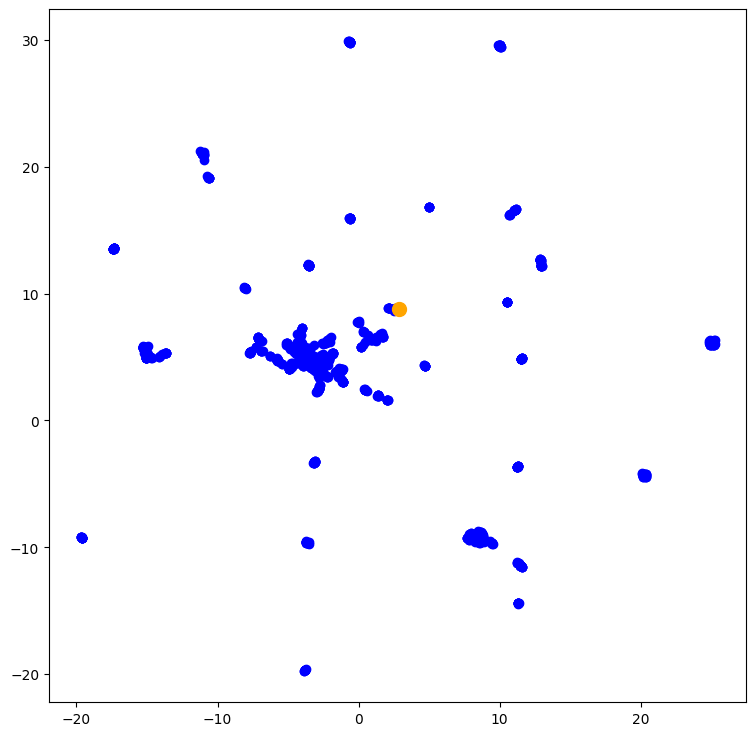

In [20]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], color="blue")
ax.scatter(umap_embeddings[:1,0], umap_embeddings[:1,1], color="orange", s=100)
plt.show()

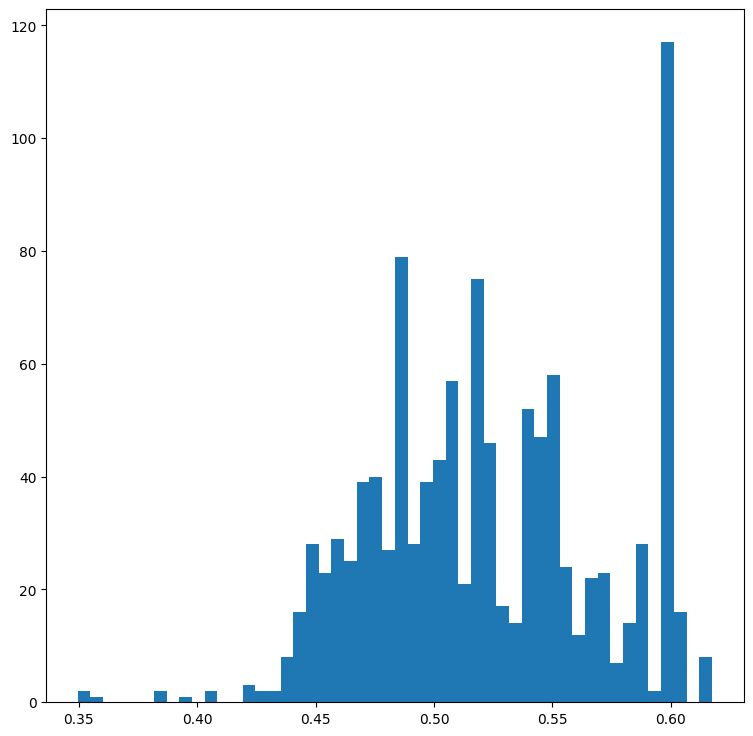

In [25]:
similarities = np.dot(species_embeddings[0,:], species_embeddings[1:,:].T)
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(similarities, bins=50)
plt.show()

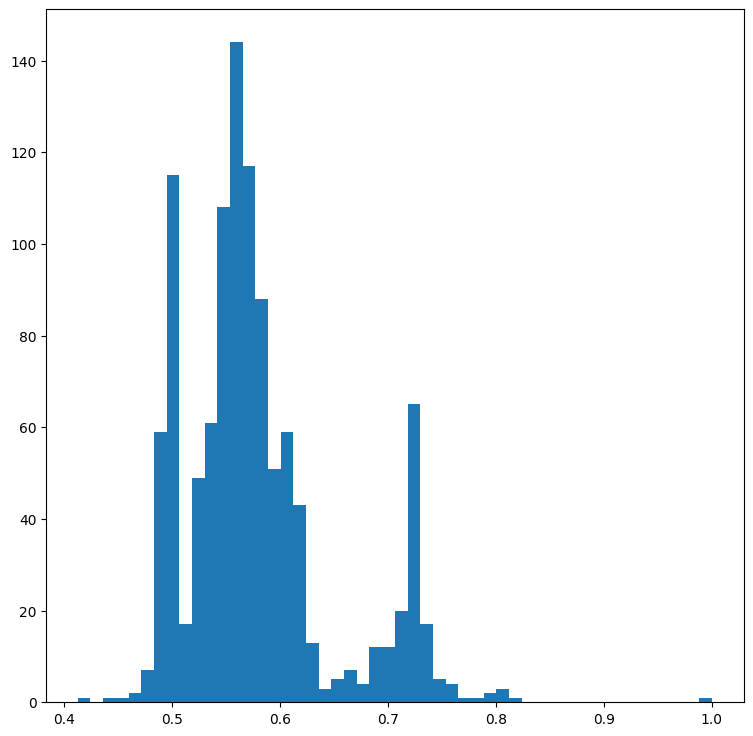

In [26]:
similarities = np.dot(species_embeddings[100,:], species_embeddings[1:,:].T)
fig, ax = plt.subplots(figsize=(9,9))
ax.hist(similarities, bins=50)
plt.show()